<a href="https://colab.research.google.com/github/heroza/Attention-based-Skin-Cancer-Classification/blob/main/ISIC%20Dataset%20using%20VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [7]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 97% 761M/786M [00:06<00:00, 135MB/s]
100% 786M/786M [00:06<00:00, 127MB/s]


In [8]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [9]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [11]:
df.head(3)

,FilePaths,Labels
0,/content/Skin cancer ISIC The International Sk...,melanoma
1,/content/Skin cancer ISIC The International Sk...,nevus
2,/content/Skin cancer ISIC The International Sk...,vascular lesion


Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

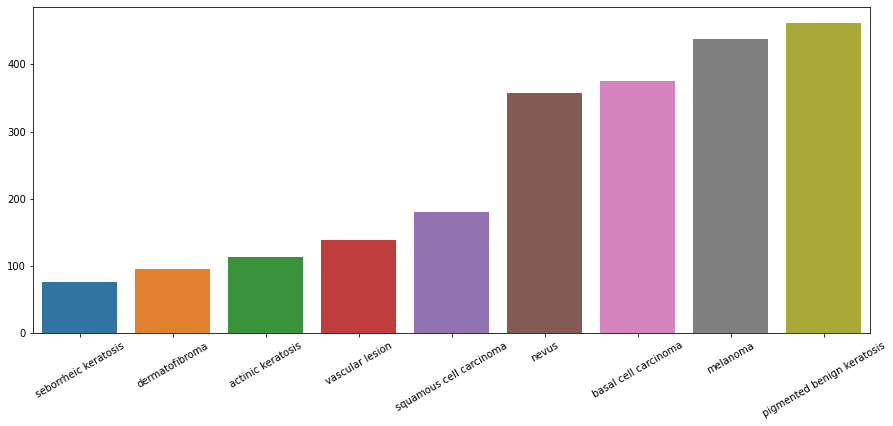

In [12]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

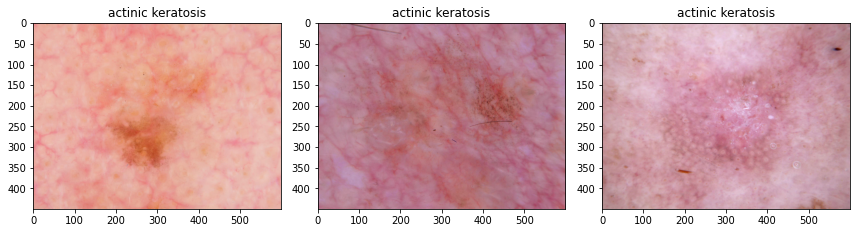

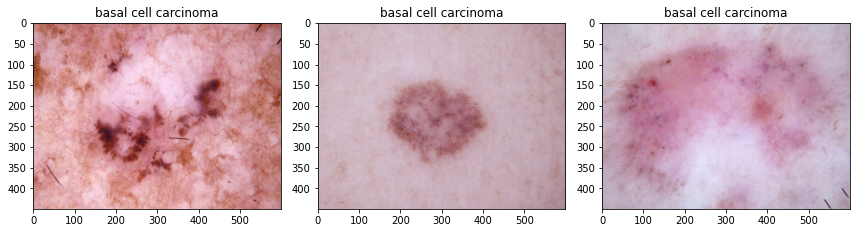

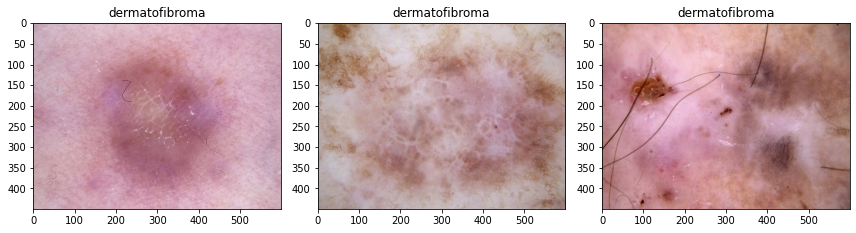

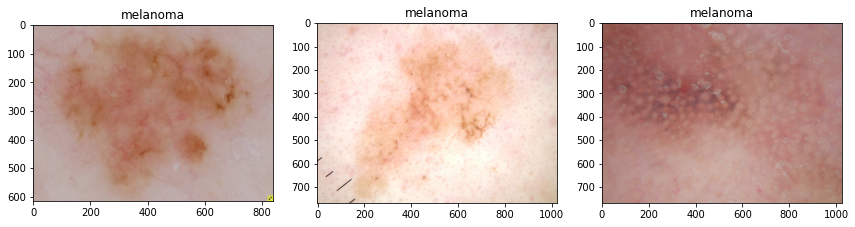

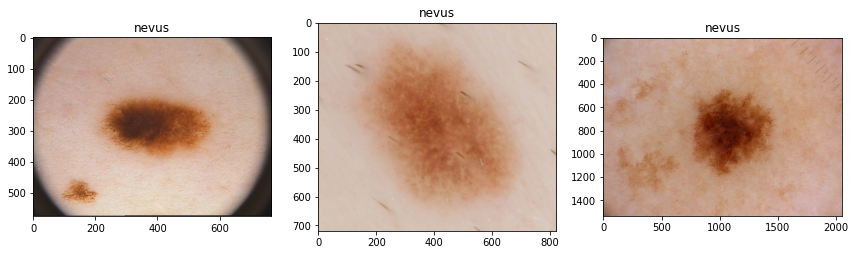

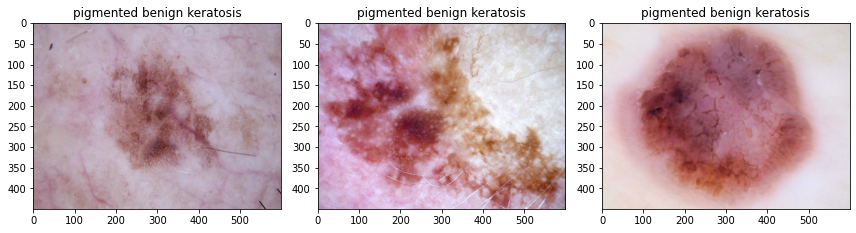

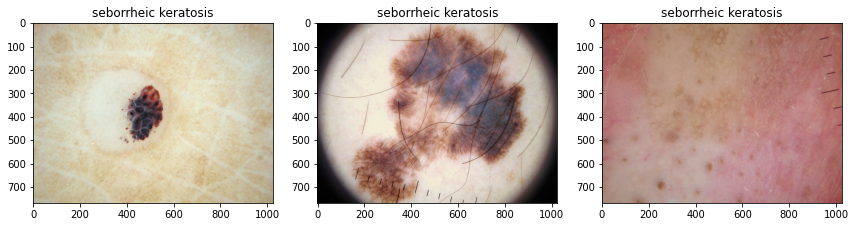

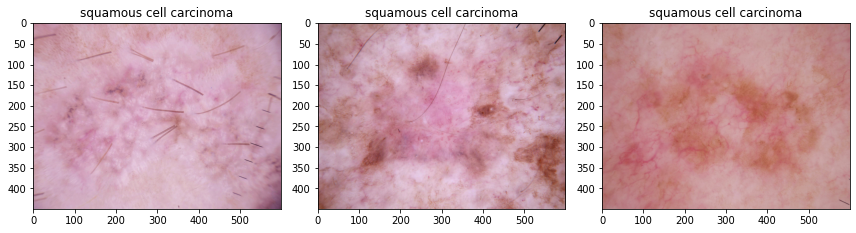

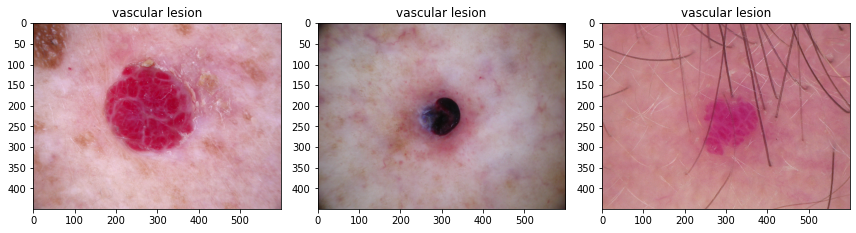

In [13]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

Split dataset to train and val

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1791, 2)
Val Data:  (448, 2)


Data Augmentation

In [16]:
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

In [17]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224, 224)

In [18]:
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

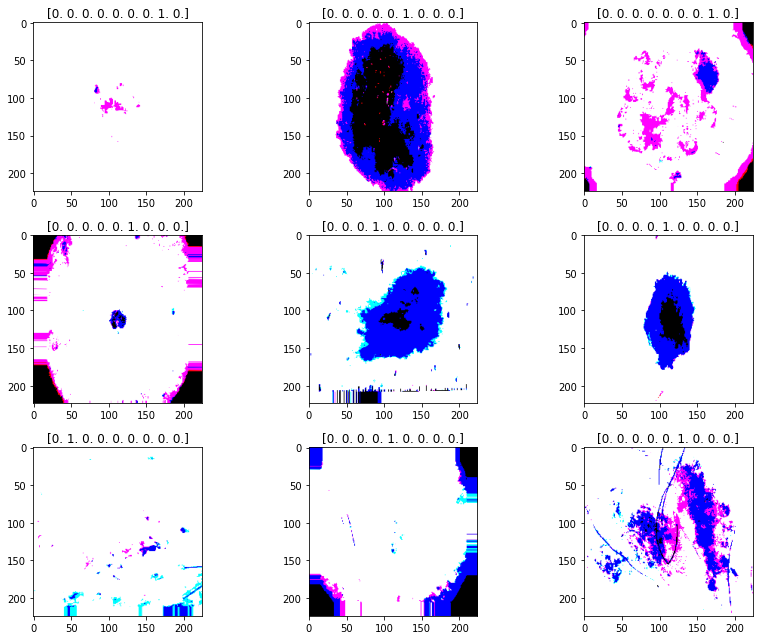

In [19]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

Create and compile the model

In [20]:
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [21]:
model = Sequential()
# scale image size to 0..1
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))

# 1. Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 2. Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# 3. Conv2D layer
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# scale to 1 dimensional input for NN
model.add(Flatten())

# hidden fully connected layer
model.add(Dense(256))
model.add(Activation('relu'))

# inhibit overfitting
model.add(Dropout(0.2))

# output fully connected layer
model.add(Dense(9))
model.add(Activation('softmax'))

# compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Model Training

In [22]:
# count of epchos
EPOCHS = 15

In [23]:
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/15
56/56 [==============================] - 299s 5s/step - loss: 19.8598 - accuracy: 0.2993 - val_loss: 33.1547 - val_accuracy: 0.0446
Epoch 2/15
56/56 [==============================] - 296s 5s/step - loss: 3.1683 - accuracy: 0.2920 - val_loss: 25.3777 - val_accuracy: 0.1741
Epoch 3/15
56/56 [==============================] - 292s 5s/step - loss: 2.0253 - accuracy: 0.2831 - val_loss: 34.3649 - val_accuracy: 0.1741
Epoch 4/15
56/56 [==============================] - 296s 5s/step - loss: 1.9332 - accuracy: 0.3166 - val_loss: 45.8237 - val_accuracy: 0.1741
Epoch 5/15
56/56 [==============================] - 294s 5s/step - loss: 1.8605 - accuracy: 0.3601 - val_loss: 42.0583 - val_accuracy: 0.1763
Epoch 6/15
56/56 [==============================] - 298s 5s/step - loss: 1.7512 - accuracy: 0.3853 - val_loss: 24.7366 - val_accuracy: 0.1897
Epoch 7/15
56/56 [==============================] - 297s 5s/step - loss: 1.7344 - accuracy: 0.3685 - val_loss: 17.5203 - val_accuracy: 0.2143
Epoch